In [59]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import stats
from datetime import datetime
dateparse = lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M')
import plotly.express as px
import plotly.graph_objects as go
from mpl_toolkits import mplot3d
from sklearn import preprocessing, svm 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
import random

In [60]:
df = pd.read_csv('./inv3_emi_data_t345678.csv',
                encoding="utf-8-sig",
                header=0,
                infer_datetime_format=True,
                parse_dates={'datetime':[5]},
                index_col=['datetime']
                )

In [61]:
df['time'] = df.index
df.loc[:,'year'] = pd.Series(df.index.year, df.index)
df.loc[:,'month'] = pd.Series(df.index.month, df.index)
df.loc[:,'day'] = pd.Series(df.index.day, df.index)
df.loc[:,'hour'] = pd.Series(df.index.hour, df.index)
df.loc[:,'dayofweek'] = pd.Series(df.index.dayofweek, df.index)
df.loc[:,'dayname'] = pd.Series(df.index.day_name(), df.index)
df.loc[:,'hourofweek'] = pd.Series((df.hour+24*df.dayofweek), df.index)
df.loc[:,'hourofmonth'] = pd.Series((df.hour+24*(df.day-1)), df.index)
df.loc[:,'date'] = pd.Series(df.index.date, df.index)
df=df[(df['Inverter status']=='Grid connected')|(df['Inverter status']=='Grid connected : power limited')]
df.head()

,Unnamed: 0.1,Unnamed: 0,Site Name,Management Domain,ManageObject_x,Ambient temperature(℃),PV Temperature(℃),Wind speed(m/s),Wind direction(°),Daily irradiation(MJ/㎡),...,time,year,month,day,hour,dayofweek,dayname,hourofweek,hourofmonth,date
datetime,,,,,,,,,,,,,,,,,,,,,
2022-03-03 14:10:00,0,0,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,25.1,32.1,4.6,NaN,0.043,...,2022-03-03 14:10:00,2022,3,3,14,3,Thursday,86,62,2022-03-03
2022-03-03 14:15:00,1,1,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,25.0,31.1,1.8,NaN,0.124,...,2022-03-03 14:15:00,2022,3,3,14,3,Thursday,86,62,2022-03-03
2022-03-03 14:20:00,2,2,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,24.7,31.0,3.1,NaN,0.208,...,2022-03-03 14:20:00,2022,3,3,14,3,Thursday,86,62,2022-03-03
2022-03-03 14:25:00,3,3,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,24.6,29.6,1.0,NaN,0.275,...,2022-03-03 14:25:00,2022,3,3,14,3,Thursday,86,62,2022-03-03
2022-03-03 14:35:00,5,5,VNM - Đà Nẵng - Nhà Máy,/BCG Energy,1020C0058922/EM001020C0058922,24.7,29.5,2.5,NaN,0.390,...,2022-03-03 14:35:00,2022,3,3,14,3,Thursday,86,62,2022-03-03


In [62]:
df1=df[df.groupby(['month','date'])['Irradiance(W/㎡)'].transform(max)==df['Irradiance(W/㎡)']]
df1.loc[:,'Tcell']=pd.Series((df1['Ambient temperature(℃)']+df1['Irradiance(W/㎡)']/800*(25-20)), df1.index)
df1.loc[:,'Pm']=pd.Series((2.172*1.303*220*2*590*df1['Irradiance(W/㎡)']/1000*(1-0.0045*(df1['Tcell']-25))*20.5/100), df1.index)
df1.loc[:,'Hieu suat']=pd.Series((df1['Total input power(kW)']*1000/df1['Pm']*100), df1.index)
df1=df1[df1['Ambient temperature(℃)']>6]
df1=df1[df1['Irradiance(W/㎡)']>300]
df1=df1[df1['Total input power(kW)']>80]
df1=df1[df1['Hieu suat']<80]
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=df1['date'],
    y=df1['Total input power(kW)'],
    name="Sản lượng điện cao nhất mỗi ngày inverter 3 "))
fig.add_trace(go.Scatter(
    x=df1['date'],
    y=df1['Hieu suat'],
    name="Hiệu suất cao nhất mỗi ngày inverter 3 "))
fig . update_traces (
    showlegend = True 
    )
fig.update_xaxes(
    rangeslider_visible=True,
)
fig.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8136\2902039425.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8136\2902039425.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_8136\2902039425.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-d

In [63]:
def estimate_coef(x, y): 
    # number of observations/points 
    n = np.size(x) 
  
    # mean of x and y vector 
    m_x, m_y = np.mean(x), np.mean(y) 
  
    # calculating cross-deviation and deviation about x 
    SS_xy = np.sum(y*x) - n*m_y*m_x 
    SS_xx = np.sum(x*x) - n*m_x*m_x 
  
    # calculating regression coefficients 
    b_1 = SS_xy / SS_xx 
    b_0 = m_y - b_1*m_x 
  
    return(b_0, b_1) 
  
def plot_regression_line(x, y, b): 
    # plotting the actual points as scatter plot 
    plt.scatter(x, y, color = "m", 
               marker = "o", s = 30) 
  
    # predicted response vector 
    y_pred = b[0] + b[1]*x 
  
    # plotting the regression line 
    plt.plot(x, y_pred, color = "g") 
  
    # putting labels 
    plt.xlabel('x') 
    plt.ylabel('y') 
  
    # function to show plot 
    plt.show() 

               datetime  Hieu suat  month  stt
0   2022-03-22 12:45:00  76.597488      3    0
1   2022-03-23 12:25:00  73.874570      3    1
2   2022-03-24 12:25:00  66.855357      3    2
3   2022-03-25 12:10:00  73.854445      3    3
4   2022-03-26 12:00:00  75.572660      3    4
..                  ...        ...    ...  ...
121 2022-08-18 12:20:00  67.681738      8  121
122 2022-08-19 11:35:00  73.073491      8  122
123 2022-08-22 13:00:00  73.243115      8  123
124 2022-08-23 11:45:00  74.658860      8  124
125 2022-08-24 11:10:00  57.837870      8  125

[126 rows x 4 columns]
Estimated coefficients:
b_0 = 69.48897492766784
b_1 = 0.013017988675492904


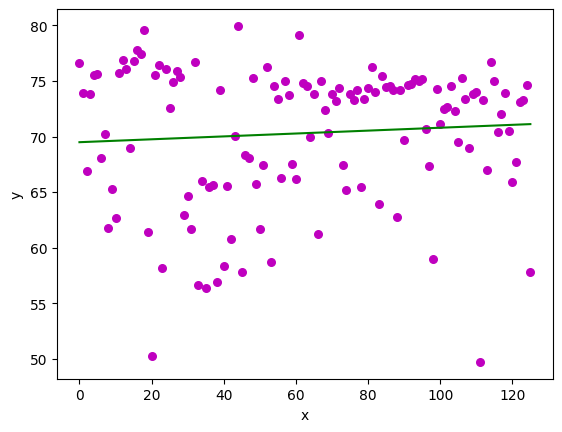

In [64]:
df_bin = df1[['Hieu suat','month']] 
x = len(df_bin)
num_index = range(0,x,1)
df_bin =  df_bin.reset_index()
df_bin.loc[:,'stt'] = pd.Series(num_index, df_bin.index)
print(df_bin)  
# Renaming the columns for easier writing of the code 
df_bin.head() 
x=df_bin['stt'].tolist()
y=df_bin['Hieu suat'].tolist()
x=np.array(x)
y=np.array(y)
b = estimate_coef(x, y) 
print("Estimated coefficients:\nb_0 = {}\nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(x, y, b) 
y_pred= b[0] + b[1]*x
fig.add_trace(go.Scatter(
    x=df1['date'],
    y=y_pred,
    name="Hiệu suất tuyến tính inverter 3 "))
fig.show()

Estimated coefficients:
b_0 = 72.7854969567329
b_1 = -0.1528025814611962


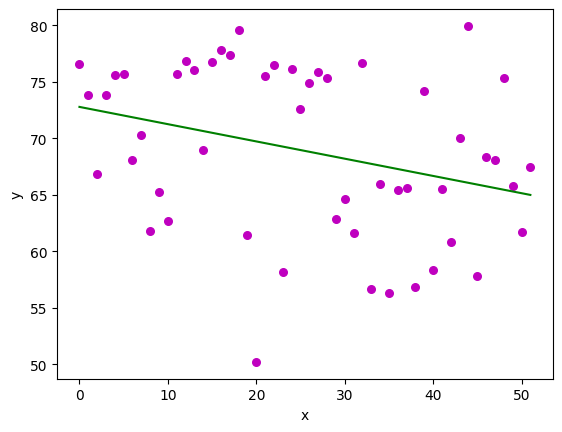

Estimated coefficients:
b_0 = 73.0551346631224
b_1 = -0.01987816187173131


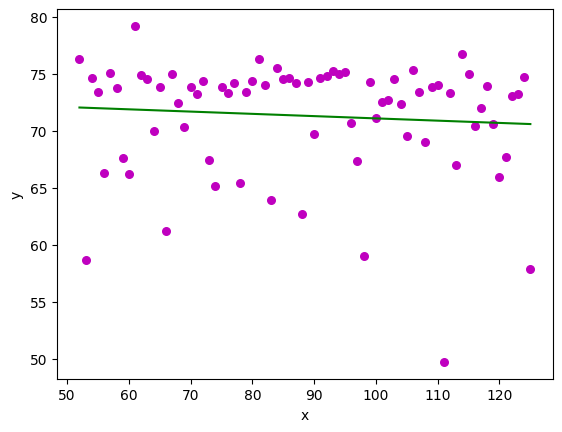

In [65]:
df2=df1[df1['month']<6]
df3=df1[df1['month']>=6]
df_bin2=df_bin[df_bin['month']<6]
df_bin3=df_bin[df_bin['month']>=6]
x=df_bin2['stt'].tolist()
y=df_bin2['Hieu suat'].tolist()
x=np.array(x)
y=np.array(y)
b = estimate_coef(x, y) 
print("Estimated coefficients:\nb_0 = {}\nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(x, y, b) 
y_pred2= b[0] + b[1]*x
x=df_bin3['stt'].tolist()
y=df_bin3['Hieu suat'].tolist()
x=np.array(x)
y=np.array(y)
b = estimate_coef(x, y) 
print("Estimated coefficients:\nb_0 = {}\nb_1 = {}".format(b[0], b[1])) 
plot_regression_line(x, y, b) 
y_pred3= b[0] + b[1]*x
fig2 = go.Figure()
fig2.add_trace(go.Scatter(
    x=df2['date'],
    y=df2['Total input power(kW)'],
    name="Sản lượng điện trung bình cao nhất theo khung giờ mỗi ngày inverter 3 "))
fig2.add_trace(go.Scatter(
    x=df2['date'],
    y=df2['Hieu suat'],
    name="Hiệu suất trung bình cao nhất theo khung giờ mỗi ngày inverter 3 "))
fig2.add_trace(go.Scatter(
    x=df2['date'],
    y=y_pred2,
    name="Hiệu suất tuyến tính inverter 3 thang3,4,5"))
fig2 . update_traces (
    showlegend = True 
    )
fig2.update_xaxes(
    rangeslider_visible=True,
    )   
fig2.show()
fig3 = go.Figure()
fig3.add_trace(go.Scatter(
    x=df3['date'],
    y=df3['Total input power(kW)'],
    name="Sản lượng điện trung bình cao nhất theo khung giờ mỗi ngày inverter 3 "))
fig3.add_trace(go.Scatter(
    x=df3['date'],
    y=df3['Hieu suat'],
    name="Hiệu suất trung bình cao nhất theo khung giờ mỗi ngày inverter 3 "))
fig3.add_trace(go.Scatter(
    x=df3['date'],
    y=y_pred3,
    name="Hiệu suất tuyến tính inverter 3 thang6,7,8"))
fig3 . update_traces (
    showlegend = True 
    )
fig3.update_xaxes(
    rangeslider_visible=True,
    )   
fig3.show()

In [66]:
array = [random.uniform(-5, 5) for _ in range(len(df2.index))]
df21=pd.DataFrame(df_bin2['month'])
df21['date']=df2.index
df21.loc[:,'Hieu suat tuyen tinh']=pd.Series((84.2467324-df21.index*0.10462134), df21.index)
df21.loc[:,'rand']=pd.Series((array), df21.index)
df21.loc[:,'Hieu suat']=pd.Series(df21['Hieu suat tuyen tinh']+df21['rand'], df21.index)
print(df21)

    month                date  Hieu suat tuyen tinh      rand  Hieu suat
0       3 2022-03-22 12:45:00             84.246732 -4.638027  79.608706
1       3 2022-03-23 12:25:00             84.142111  3.399545  87.541656
2       3 2022-03-24 12:25:00             84.037490 -4.420976  79.616514
3       3 2022-03-25 12:10:00             83.932868 -1.429078  82.503791
4       3 2022-03-26 12:00:00             83.828247  2.855168  86.683415
5       3 2022-03-28 13:15:00             83.723626  0.779175  84.502801
6       3 2022-03-29 10:45:00             83.619004 -3.947782  79.671222
7       3 2022-03-30 12:25:00             83.514383 -4.088850  79.425533
8       4 2022-04-03 13:05:00             83.409762  4.665503  88.075265
9       4 2022-04-04 12:35:00             83.305140 -0.887888  82.417253
10      4 2022-04-06 12:15:00             83.200519 -1.904031  81.296488
11      4 2022-04-07 11:40:00             83.095898  4.965640  88.061538
12      4 2022-04-08 11:45:00             82.991276

In [67]:
array = [random.uniform(-5, 5) for _ in range(len(df3.index))]
df31=pd.DataFrame(df_bin3['month'])
df31['date']=df3.index
df31.loc[:,'Hieu suat tuyen tinh']=pd.Series((df21['Hieu suat tuyen tinh'][51]-df31.index*0.02974613), df31.index)
df31.loc[:,'rand']=pd.Series((array), df31.index)
df31.loc[:,'Hieu suat']=pd.Series(df31['Hieu suat tuyen tinh']+df31['rand'], df31.index)
print(df31)

     month                date  Hieu suat tuyen tinh      rand  Hieu suat
52       6 2022-06-01 12:00:00             77.364245 -1.507756  75.856489
53       6 2022-06-02 10:35:00             77.334499  4.370504  81.705003
54       6 2022-06-03 11:25:00             77.304753 -4.576772  72.727981
55       6 2022-06-04 11:10:00             77.275007  3.293990  80.568997
56       6 2022-06-05 11:50:00             77.245261 -1.265580  75.979681
..     ...                 ...                   ...       ...        ...
121      8 2022-08-18 12:20:00             75.311762  4.705477  80.017239
122      8 2022-08-19 11:35:00             75.282016  4.558700  79.840717
123      8 2022-08-22 13:00:00             75.252270 -3.183537  72.068733
124      8 2022-08-23 11:45:00             75.222524  0.984840  76.207364
125      8 2022-08-24 11:10:00             75.192778  1.690200  76.882978

[74 rows x 5 columns]


In [68]:
fig21 = go.Figure()
fig21.add_trace(go.Scatter(
    x=df21['date'],
    y=df21['Hieu suat'],
    name="Hiệu suất trung bình cao nhất theo khung giờ mỗi ngày inverter 3 tháng 3,4,5 "))
fig21.add_trace(go.Scatter(
    x=df21['date'],
    y=df21['Hieu suat tuyen tinh'],
    name="Hiệu suất tuyến tính inverter 3 tháng 3,4,5"))
fig21.update_layout(yaxis_range=[0, 100])
fig21.show()

In [69]:
fig31 = go.Figure()
fig31.add_trace(go.Scatter(
    x=df31['date'],
    y=df31['Hieu suat'],
    name="Hiệu suất trung bình cao nhất theo khung giờ mỗi ngày inverter 3 tháng 6,7,8 "))
fig31.add_trace(go.Scatter(
    x=df31['date'],
    y=df31['Hieu suat tuyen tinh'],
    name="Hiệu suất tuyến tính inverter 3 tháng 6,7,8"))
fig31.update_layout(yaxis_range=[0, 100])
fig31.show()

     index  Hieu suat  month  stt
0        0  79.608706      3    0
1        1  87.541656      3    1
2        2  79.616514      3    2
3        3  82.503791      3    3
4        4  86.683415      3    4
..     ...        ...    ...  ...
121    121  80.017239      8  121
122    122  79.840717      8  122
123    123  72.068733      8  123
124    124  76.207364      8  124
125    125  76.882978      8  125

[126 rows x 4 columns]
Estimated coefficients:
b_0 = 82.69332660454211
b_1 = -0.06997734414164171


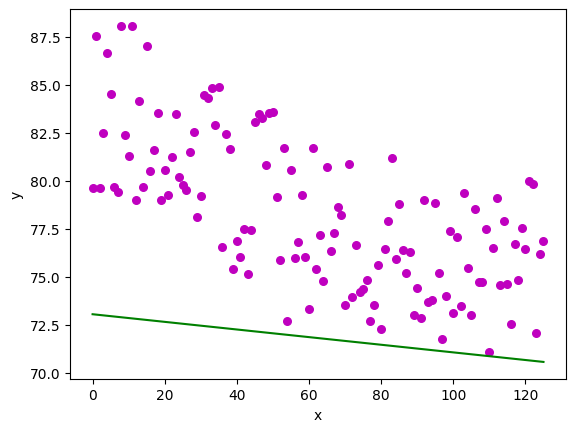

In [70]:
df11=df21.merge(df31, how='outer')
df_bin11 = df11[['Hieu suat','month']] 
x = len(df_bin11)
num_index = range(0,x,1)
df_bin11 =  df_bin11.reset_index()
df_bin11.loc[:,'stt'] = pd.Series(num_index, df_bin11.index)
print(df_bin11)  
# Renaming the columns for easier writing of the code 
df_bin11.head() 
x=df_bin11['stt'].tolist()
y=df_bin11['Hieu suat'].tolist()
x=np.array(x)
y=np.array(y)
b1 = estimate_coef(x, y) 
print("Estimated coefficients:\nb_0 = {}\nb_1 = {}".format(b1[0], b1[1])) 
plot_regression_line(x, y, b) 
y_pred= b1[0] + b1[1]*x
fig11 = go.Figure()
fig11.add_trace(go.Scatter(
    x=df11.index,
    y=df11['Hieu suat'],
    name="Hiệu suất inverter 3 "))
fig11.add_trace(go.Scatter(
    x=df11.index,
    y=y_pred,
    name="Hiệu suất tuyến tính inverter 3 "))
fig11.update_layout(yaxis_range=[0, 100])
fig11.show()